In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

# local utils
import utils

%matplotlib inline

In [2]:
# Create a database connection using settings from config file
config='db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con_eicu = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con_eicu = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con_eicu = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
eicu_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


In [3]:
# Create a database connection using settings from config file
config='db/config-mimic.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con_mimic = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con_mimic = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con_mimic = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
mimic_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: mimic
Username: alistairewj


## eICU - Random time design matrix 

In [4]:
query = eicu_schema + """
select co.*, tm.windowtime_hours
from tr_cohort co
left join tr_time_random tm
on co.patientunitstayid = tm.patientunitstayid
"""
co_eicu = pd.read_sql_query(query, con_eicu)
co_eicu.set_index('patientunitstayid', inplace=True)

co_eicu = utils.drop_patients(co_eicu)

   181 removed due to exclusion_non_adult
 16311 removed due to exclusion_bad_data
     0 removed due to exclusion_organ_donor
100996 removed due to exclusion_by_apache

107087 (53.31%) removed so far.
  extra   9043 removed due to window time.

 84729 (42.18%) - final cohort size.


In [5]:
query = eicu_schema + """
select d.*
from tr_time_random tr
inner join tr_data d
on tr.patientunitstayid = d.patientunitstayid
and d.hr <= tr.windowtime_hours
order by 1, 2
"""
df_eicu = pd.read_sql_query(query, con_eicu)

In [6]:
query = eicu_schema + """select * from tr_static_data"""
df_eicu_static = pd.read_sql_query(query, con_eicu)
df_eicu_static.set_index('patientunitstayid', inplace=True)

### Combine dataframes together and create design matrix

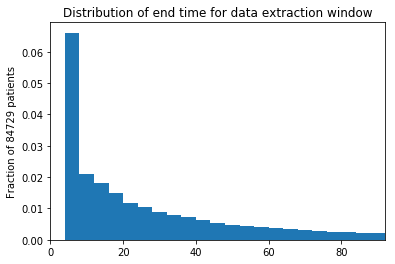

In [7]:
plt.figure()
xi = np.append(np.arange(0, 96, 4), 1000)
plt.hist(co_eicu['windowtime_hours'], bins=xi, normed=True)
plt.xlim([xi[0], xi[-2]])
plt.title('Distribution of end time for data extraction window')
plt.ylabel('Fraction of {} patients'.format(co_eicu.shape[0]))
plt.show()

In [11]:
eicu_time_dict = co_eicu['windowtime_hours'].to_dict()
X_eicu = utils.get_design_matrix(df_eicu, eicu_time_dict,
                                 pt_id_col='patientunitstayid',
                                 W=8, W_extra=24)

# add in outcomes/static vars to the design matrix
vars_static = ['death', 'ventdays',
               'is_female', 'age',
               'race_black', 'race_hispanic', 'race_asian', 'race_other',
               'electivesurgery']
X_eicu = X_eicu.merge(df_eicu_static[vars_static], how='inner',
                       left_index=True, right_index=True)

# add in hospitalid/outcomes to start of dataframe
vars_outcome = ['hospitalid', 'hosp_los']
X_eicu = co_eicu[vars_outcome].merge(X_eicu, how='inner',
              left_index=True, right_index=True)

# rearrange certain columns to beginning of dataframe
# this is only for aesthetics - nice to have non-inputs at start of df
vars_outcome = ['hospitalid', 'death', 'hosp_los', 'ventdays']
X_eicu = X_eicu[ vars_outcome + [c for c in X_eicu.columns if c not in vars_outcome] ]
X_eicu.head()

,hospitalid,death,hosp_los,ventdays,heartrate_first,sysbp_first,diasbp_first,meanbp_first,resprate_first,tempc_first,...,spo2_max,gcs_max,urineoutput_sum,is_female,age,race_black,race_hispanic,race_asian,race_other,electivesurgery
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141194,73,0,9.340972,0,69.0,144.0,82.0,NaN,20.0,36.9,...,96.0,NaN,325.0,0,68.0,0,0,0,1,0
141203,66,0,3.957639,2,68.0,104.0,62.0,NaN,24.0,36.7,...,97.0,NaN,NaN,1,77.0,0,0,0,1,0
141208,73,0,0.515972,0,107.0,159.0,91.0,87.0,20.0,36.9,...,95.5,13.0,NaN,1,25.0,0,0,0,1,0
141227,60,0,2.743056,2,110.0,101.0,57.0,NaN,22.0,37.9,...,97.0,NaN,600.0,0,82.0,0,0,0,1,0
141233,73,0,16.224306,2,96.0,108.0,58.0,74.0,21.0,36.4,...,100.0,15.0,1520.0,1,81.0,0,0,0,1,1


In [13]:
# write to file
X_eicu.to_csv('X_eicu.csv.gz', compression='gzip')

## MIMIC-III - Random time matrix

In [14]:
query = mimic_schema + """
select co.*, tm.windowtime_hours
from tr_cohort co
left join tr_time_random tm
on co.icustay_id = tm.icustay_id"""
co_mimic = pd.read_sql_query(query, con_mimic)
co_mimic.set_index('icustay_id', inplace=True)
co_mimic = utils.drop_patients(co_mimic)

  8109 removed due to exclusion_non_adult
  1347 removed due to exclusion_bad_data
     4 removed due to exclusion_organ_donor
 18691 removed due to exclusion_by_apache

 23825 (38.72%) removed so far.
  extra   1525 removed due to window time.

 36182 (58.80%) - final cohort size.


In [15]:
query = mimic_schema + """
select d.*
from tr_time_random tr
inner join tr_data d
on tr.icustay_id = d.icustay_id
and d.hr <= tr.windowtime_hours
order by 1, 2
"""
df_mimic = pd.read_sql_query(query, con_mimic)

In [16]:
query = mimic_schema + """select * from tr_static_data"""
df_mimic_static = pd.read_sql_query(query, con_mimic)
df_mimic_static.set_index('icustay_id', inplace=True)

### Summarize and create dataframe

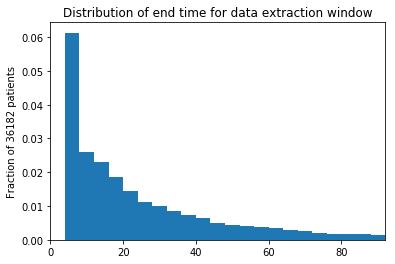

In [17]:
plt.figure()
xi = np.append(np.arange(0, 96, 4), 1000)
plt.hist(co_mimic['windowtime_hours'], bins=xi, normed=True)
plt.xlim([xi[0], xi[-2]])
plt.title('Distribution of end time for data extraction window')
plt.ylabel('Fraction of {} patients'.format(co_mimic.shape[0]))
plt.show()

In [19]:
mimic_time_dict = co_mimic['windowtime_hours'].to_dict()
X_mimic = utils.get_design_matrix(df_mimic, mimic_time_dict,
                            pt_id_col='icustay_id',
                            W=8, W_extra=24)

# add in outcomes/static vars to the design matrix
vars_static = ['death', 'ventdays',
               'is_female', 'age',
               'race_black', 'race_hispanic', 'race_asian', 'race_other',
               'electivesurgery']
X_mimic = X_mimic.merge(df_mimic_static[vars_static], how='inner',
                       left_index=True, right_index=True)

# add in hospitalid/outcomes to start of dataframe
vars_outcome = ['hospitalid', 'hosp_los']
X_mimic = co_mimic[vars_outcome].merge(X_mimic, how='inner',
              left_index=True, right_index=True)

# rearrange certain columns to beginning of dataframe
# this is only for aesthetics - nice to have non-inputs at start of df
vars_outcome = ['hospitalid', 'death', 'hosp_los', 'ventdays']
X_mimic = X_mimic[ vars_outcome + [c for c in X_mimic.columns if c not in vars_outcome] ]
X_mimic.head()

,hospitalid,death,hosp_los,ventdays,heartrate_first,sysbp_first,diasbp_first,meanbp_first,resprate_first,tempc_first,...,spo2_max,gcs_max,urineoutput_sum,is_female,age,race_black,race_hispanic,race_asian,race_other,electivesurgery
icustay_id,,,,,,,,,,,,,,,,,,,,,
200003,0,0,20.081944,4,125.5,98.5,58.500000,65.500000,30.00,39.555554,...,97.0,15.0,1014.0,0,48.2940,0,0,0,0,0
200007,0,0,3.239583,0,97.0,120.0,62.333333,81.555567,21.75,37.611109,...,96.0,15.0,250.0,0,43.3439,0,0,0,0,0
200009,0,0,6.177083,1,109.0,114.0,61.000000,78.000000,28.00,37.599998,...,100.0,15.0,405.0,1,47.5548,0,0,0,0,1
200012,0,0,0.425694,0,103.5,99.5,72.500000,78.000000,18.00,37.500000,...,99.0,15.0,650.0,1,32.9891,0,0,1,0,0
200014,0,0,4.604861,1,63.0,103.0,52.000000,68.000000,12.00,36.500000,...,100.0,14.0,95.0,0,84.7301,0,0,0,1,0


In [20]:
# write to file
X_mimic.to_csv('X_mimic.csv.gz', compression='gzip')

## Close DB connections

In [21]:
con_mimic.close()
con_eicu.close()